In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

plt.rcParams['figure.facecolor'] = 'lightgray'

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

R2: 0.2907


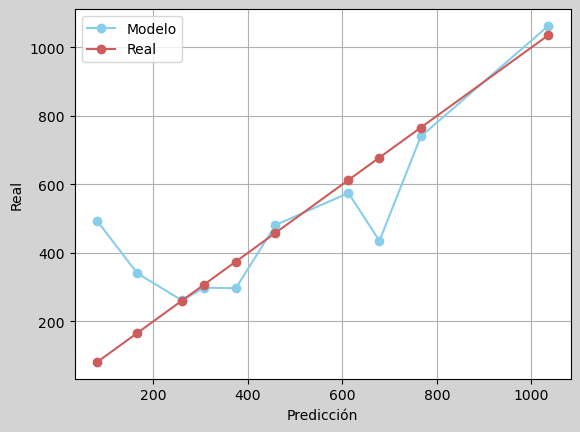

In [4]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')
calibracion(y_pred, y_test, 10)

## Modelos Boosting

In [5]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

### XGBoost

In [6]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    reg_lambda=0.1,
    subsample=0.5,
    colsample_bytree=0.8,
    tree_method='hist',
    early_stopping_rounds=20,
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

[0]	validation_0-rmse:425.49968	validation_1-rmse:406.10652
[56]	validation_0-rmse:41.61278	validation_1-rmse:300.61707


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

R2: 0.5124


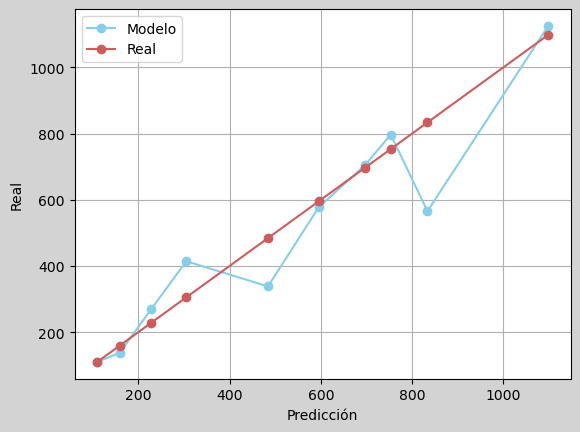

In [7]:
predicciones = model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print(f'R2: {r2:.4f}')
calibracion(predicciones, y_test, 10)

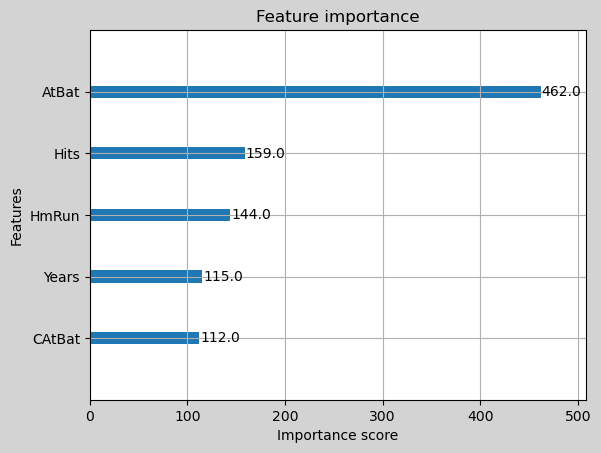

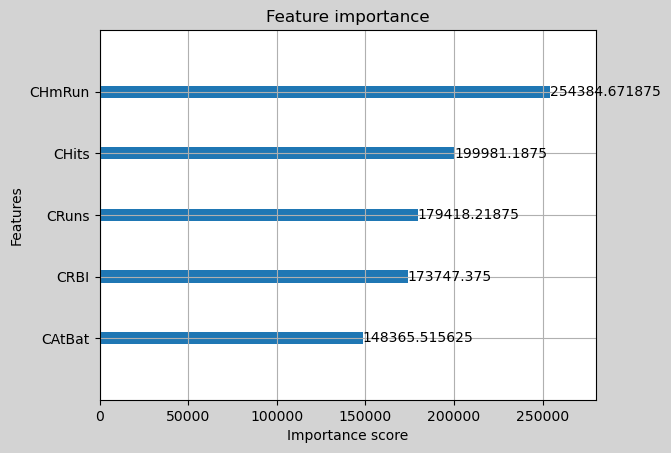

In [8]:
from xgboost import plot_importance
plot_importance(model, max_num_features=5, importance_type='weight');
plot_importance(model, max_num_features=5, importance_type='gain');

### Lightgbm

In [9]:
model = LGBMRegressor(
    n_estimators=1000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=8,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's rmse: 266.635	training's l2: 71094	valid_1's rmse: 361.72	valid_1's l2: 130842


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=8,
              n_estimators=1000, num_leaves=10, subsample=0.8, verbosity=-1)

R2: 0.2766


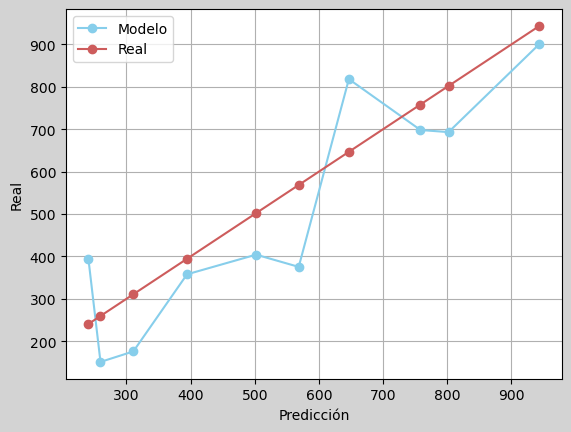

In [10]:
predicciones = model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print(f'R2: {r2:.4f}')
calibracion(predicciones, y_test, 10)

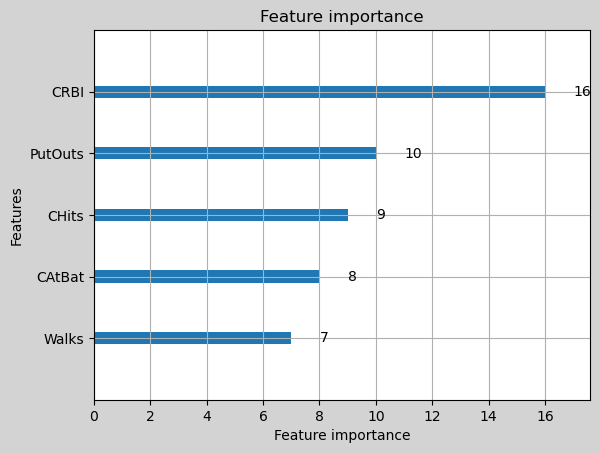

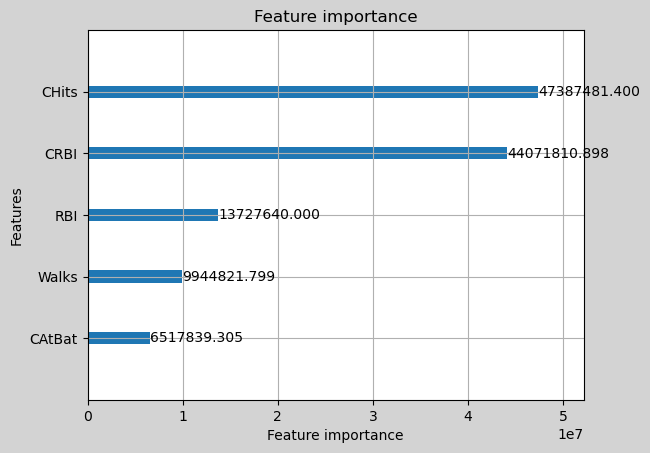

In [11]:
from lightgbm import plot_importance
plot_importance(model, max_num_features=5, importance_type='split');
plot_importance(model, max_num_features=5, importance_type='gain');

### Catboost

In [12]:
data = pd.read_csv('Hitters.csv')
target = 'Salary'
data = data[data['Salary'].notnull()]

# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Paso 2: Detectar columnas categóricas (número bajo de categorías)
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

# Paso 3: Forzar columnas categóricas a string y llenar nulos
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [14]:
model = CatBoostRegressor(
    iterations=1000,           
    depth=8,                   
    learning_rate=0.1,
    subsample=0.5,              
    rsm=0.8,                    
    eval_metric='R2',           
    l2_leaf_reg=0.1,            
    random_strength=5,          
    verbose=100,
    early_stopping_rounds=20    
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

0:	learn: 0.0876827	test: 0.0357651	best: 0.0357651 (0)	total: 62.9ms	remaining: 1m 2s
100:	learn: 0.9979535	test: 0.4230336	best: 0.4230336 (100)	total: 340ms	remaining: 3.03s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4244069385
bestIteration = 117

Shrink model to first 118 iterations.


R2: 0.4244


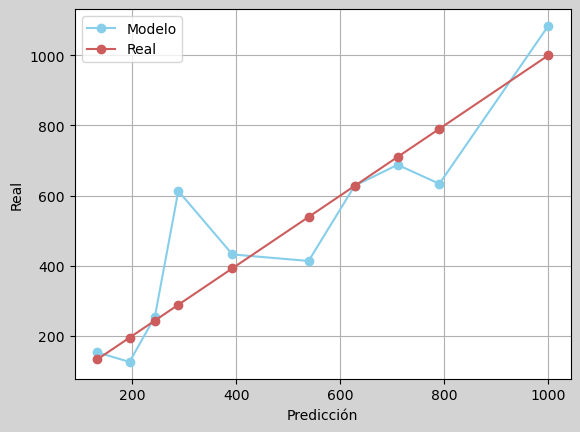

In [15]:
predicciones = model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print(f'R2: {r2:.4f}')
calibracion(predicciones, y_test, 10)

In [16]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

df_importances.head()

,feature,importance
12,CWalks,9.880329
2,HmRun,8.180783
9,CHmRun,7.539093
6,Years,5.600743
23,CHits_per_CAtBat,5.198792


## Conclusiones

El mejor modelo fue el de XGBoost, lo cual hace sentido ya que es más robusto que lightgbm y el modelo de Catboost funciona mejor cuando hay muchas variables categóricas, el cual no es el caso para este dataset donde la gran mayoría de variables son numéricas. Como detalle importante cabe resaltar que la regresión lineal obtuvo un mejor resultado de r2 que el modelo de lightgbm.

Si bien ningún modelo tiene un gran r2, puesto que el más alto fue el 0.51 de XGBoost, es una mejora considerable a la regresión lineal, sin realizar feature engineering.

Las importancias de los modelos en el XGBoost las variales más utilizadas son AtBat, Hits y HmRun, y las que más reducen la varianza son CHits, CRuns y CHmRun. Las variables utilzadas en cada caso son completamente diferentes, por lo que utilizarlas muchas veces no implica una mejora dentro del modelo.

Para lightgbm las variables más utilizadas son Years, CRBI, CHits_per_CAtBat, mientras que las que más reducen la varianza CRBI, 